In [1]:
import config
from config import *
%matplotlib inline

2022-01-30 15:47:40.525275: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [36]:
class XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
        
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_K[idx])/np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_P[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Ni[idx])/np.amax(self.Patches_K[idx]),
            np.amax(self.Patches_Cu[idx])/np.amax(self.Patches_K[idx])
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [37]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img
X1=x.features
X1.shape

(110, 14)

In [38]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
X2=x.features
X2.shape

(41, 14)

In [39]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img
X3=x.features
X3.shape

(43, 14)

In [40]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img
X4=x.features
X4.shape

(53, 14)

In [41]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin5=x.binary_img
X5=x.features
X5.shape

(55, 14)

In [42]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img
X6=x.features
X6.shape

(39, 14)

In [43]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img
X7=x.features
X7.shape

(57, 14)

In [44]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img
X8=x.features
X8.shape

(61, 14)

In [45]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img
X9=x.features
X9.shape

(31, 14)

In [46]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img
X10=x.features
X10.shape

(64, 14)

In [47]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))

In [48]:
X.shape

(554, 14)

In [49]:
X_bin.shape

(554, 32, 32)

In [93]:
def viewer(idx):

    plt.imshow(X_bin[idx]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [51]:
X[0]

array([3.12500000e-01, 0.00000000e+00, 6.30783131e-01, 6.32455532e-01,
       6.32455532e-01, 1.41421356e+00, 2.85727874e-05, 9.52823699e-01,
       2.86160812e-05, 9.54267442e-01, 2.85584442e-02, 4.05041665e-01,
       1.00151527e+00, 3.50689697e+01])

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(X)

# reduced_X = PCA(=2).fit(X)

In [53]:
X_standard[0]

array([-1.03765961, -1.69432343, -1.24468001, -1.0746984 , -0.79013015,
       -1.04179638, -0.61902571, -0.5395354 , -0.90463501, -0.11989723,
       -0.55856562, -1.01793418,  0.07596778,  0.55433046])

In [54]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [413]:
pca.singular_values_

array([53.98709552, 48.06555871])

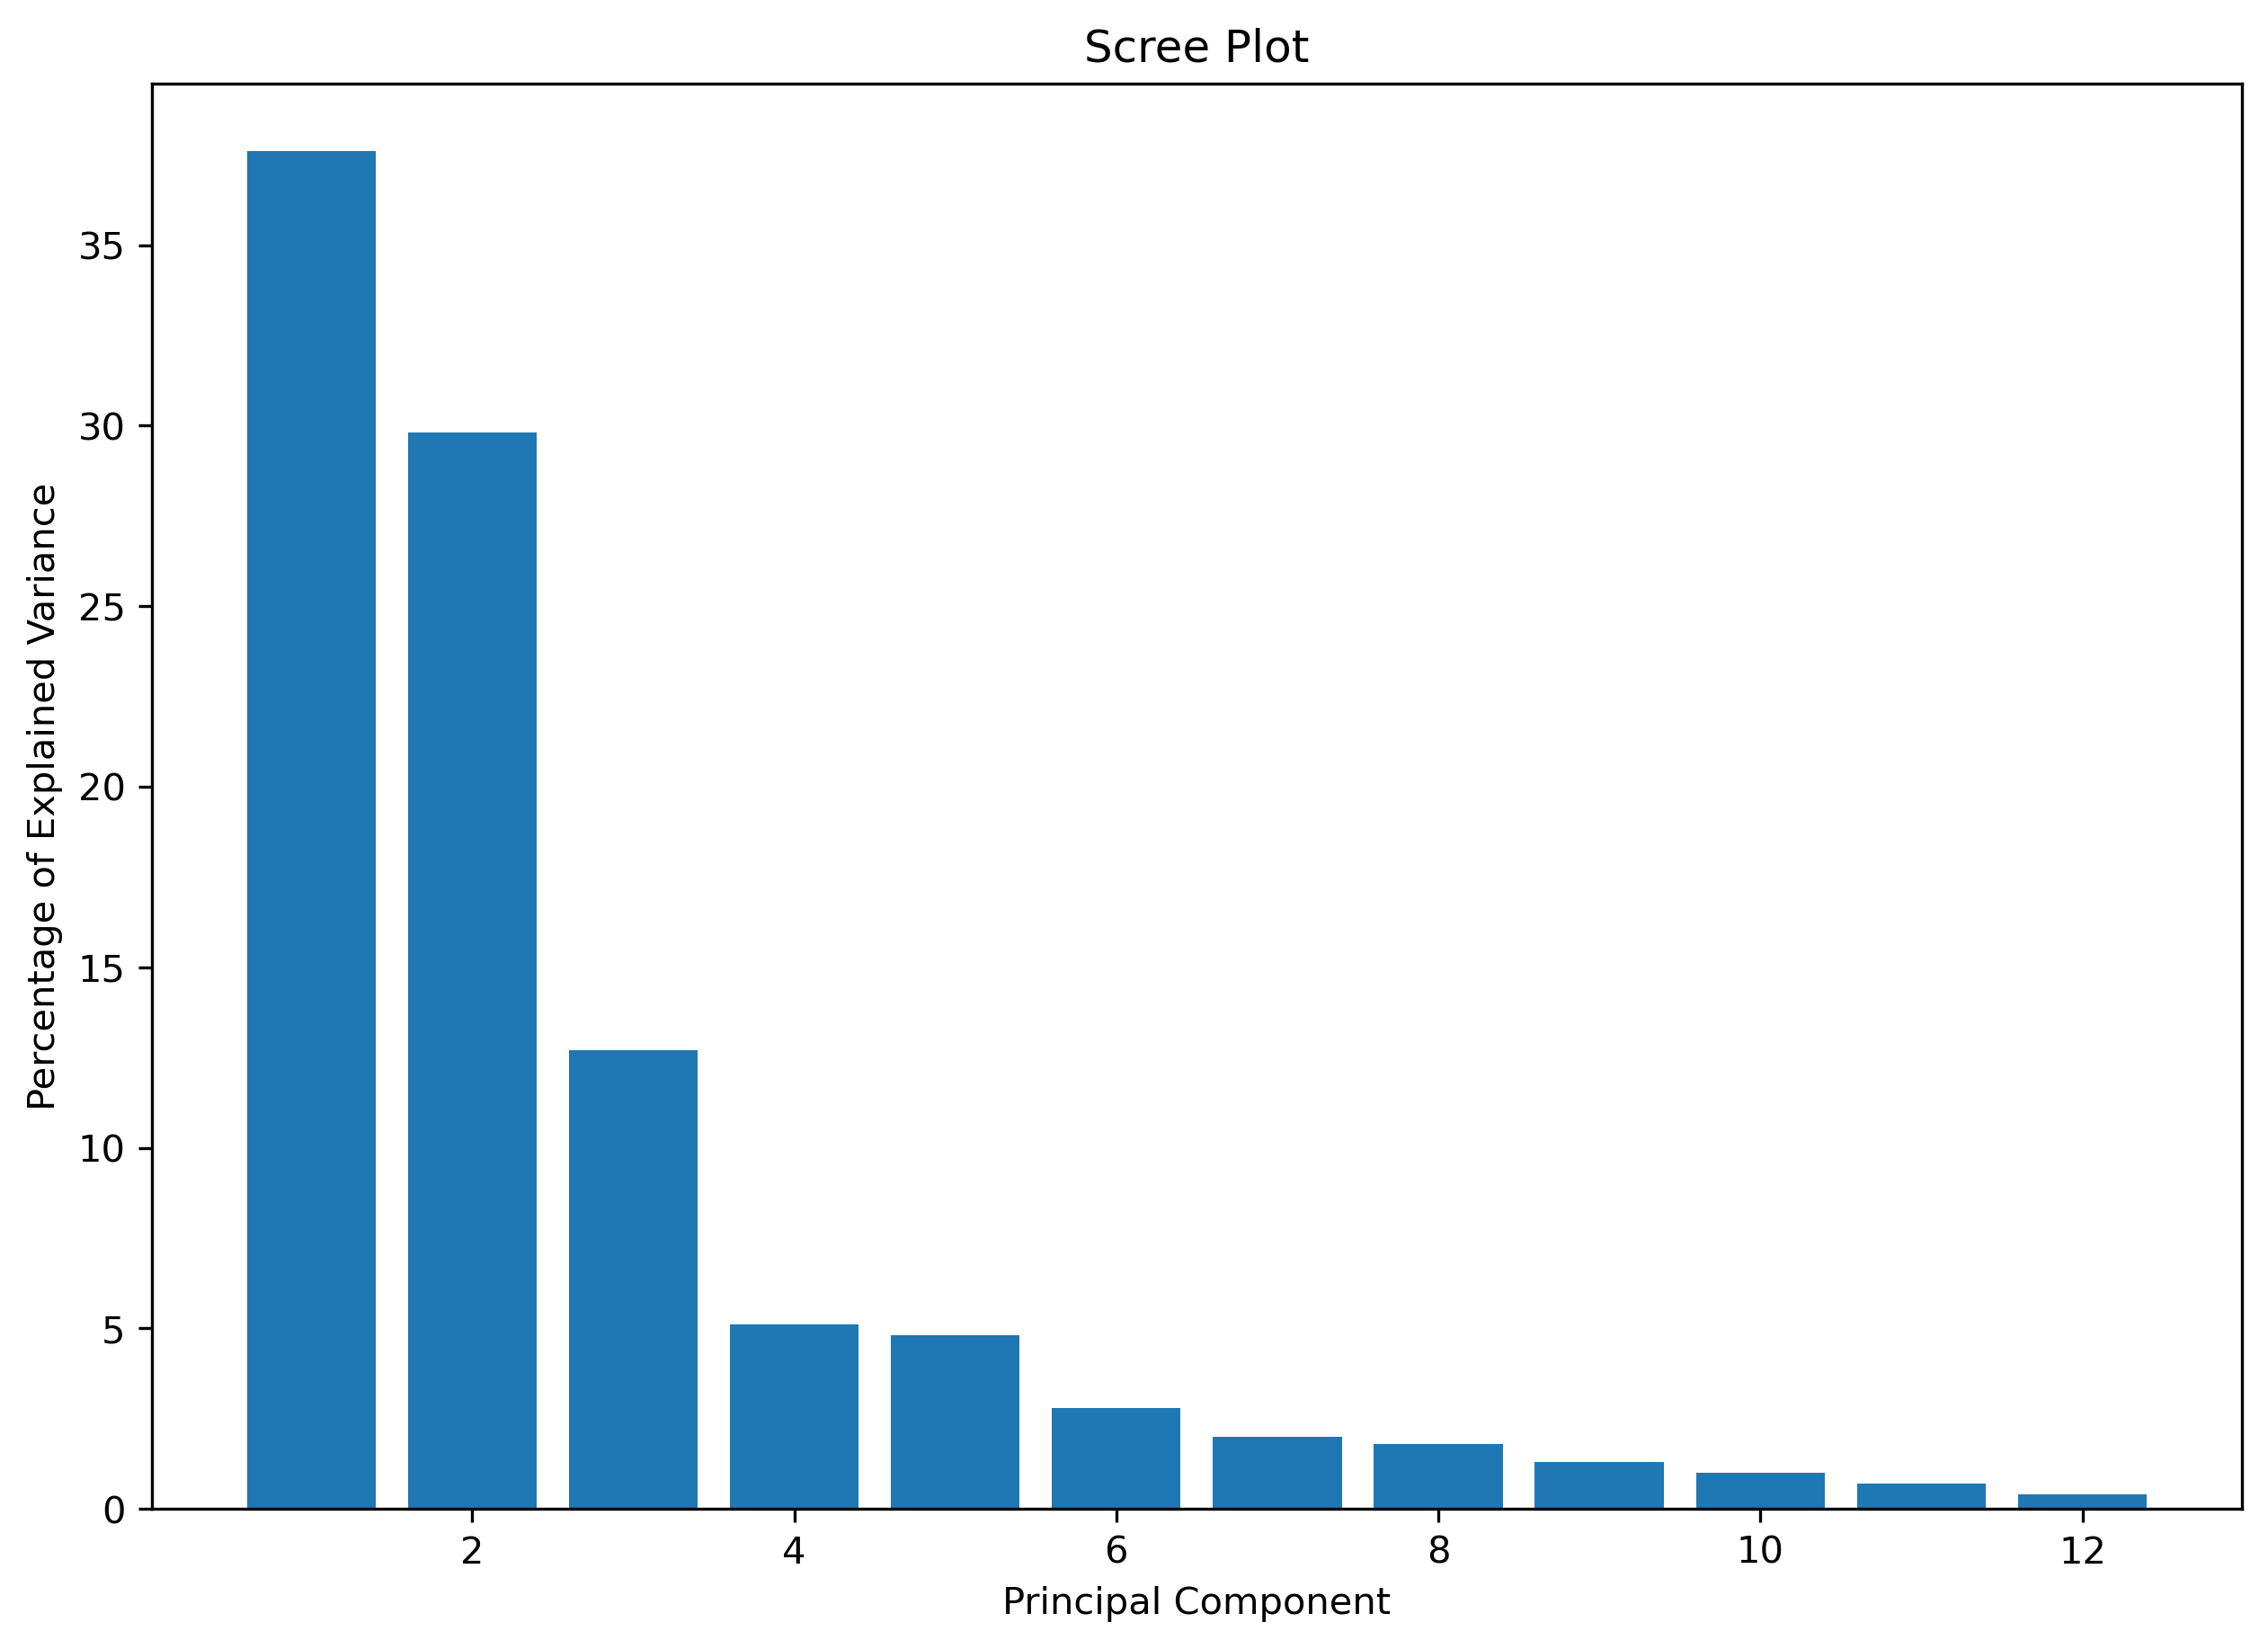

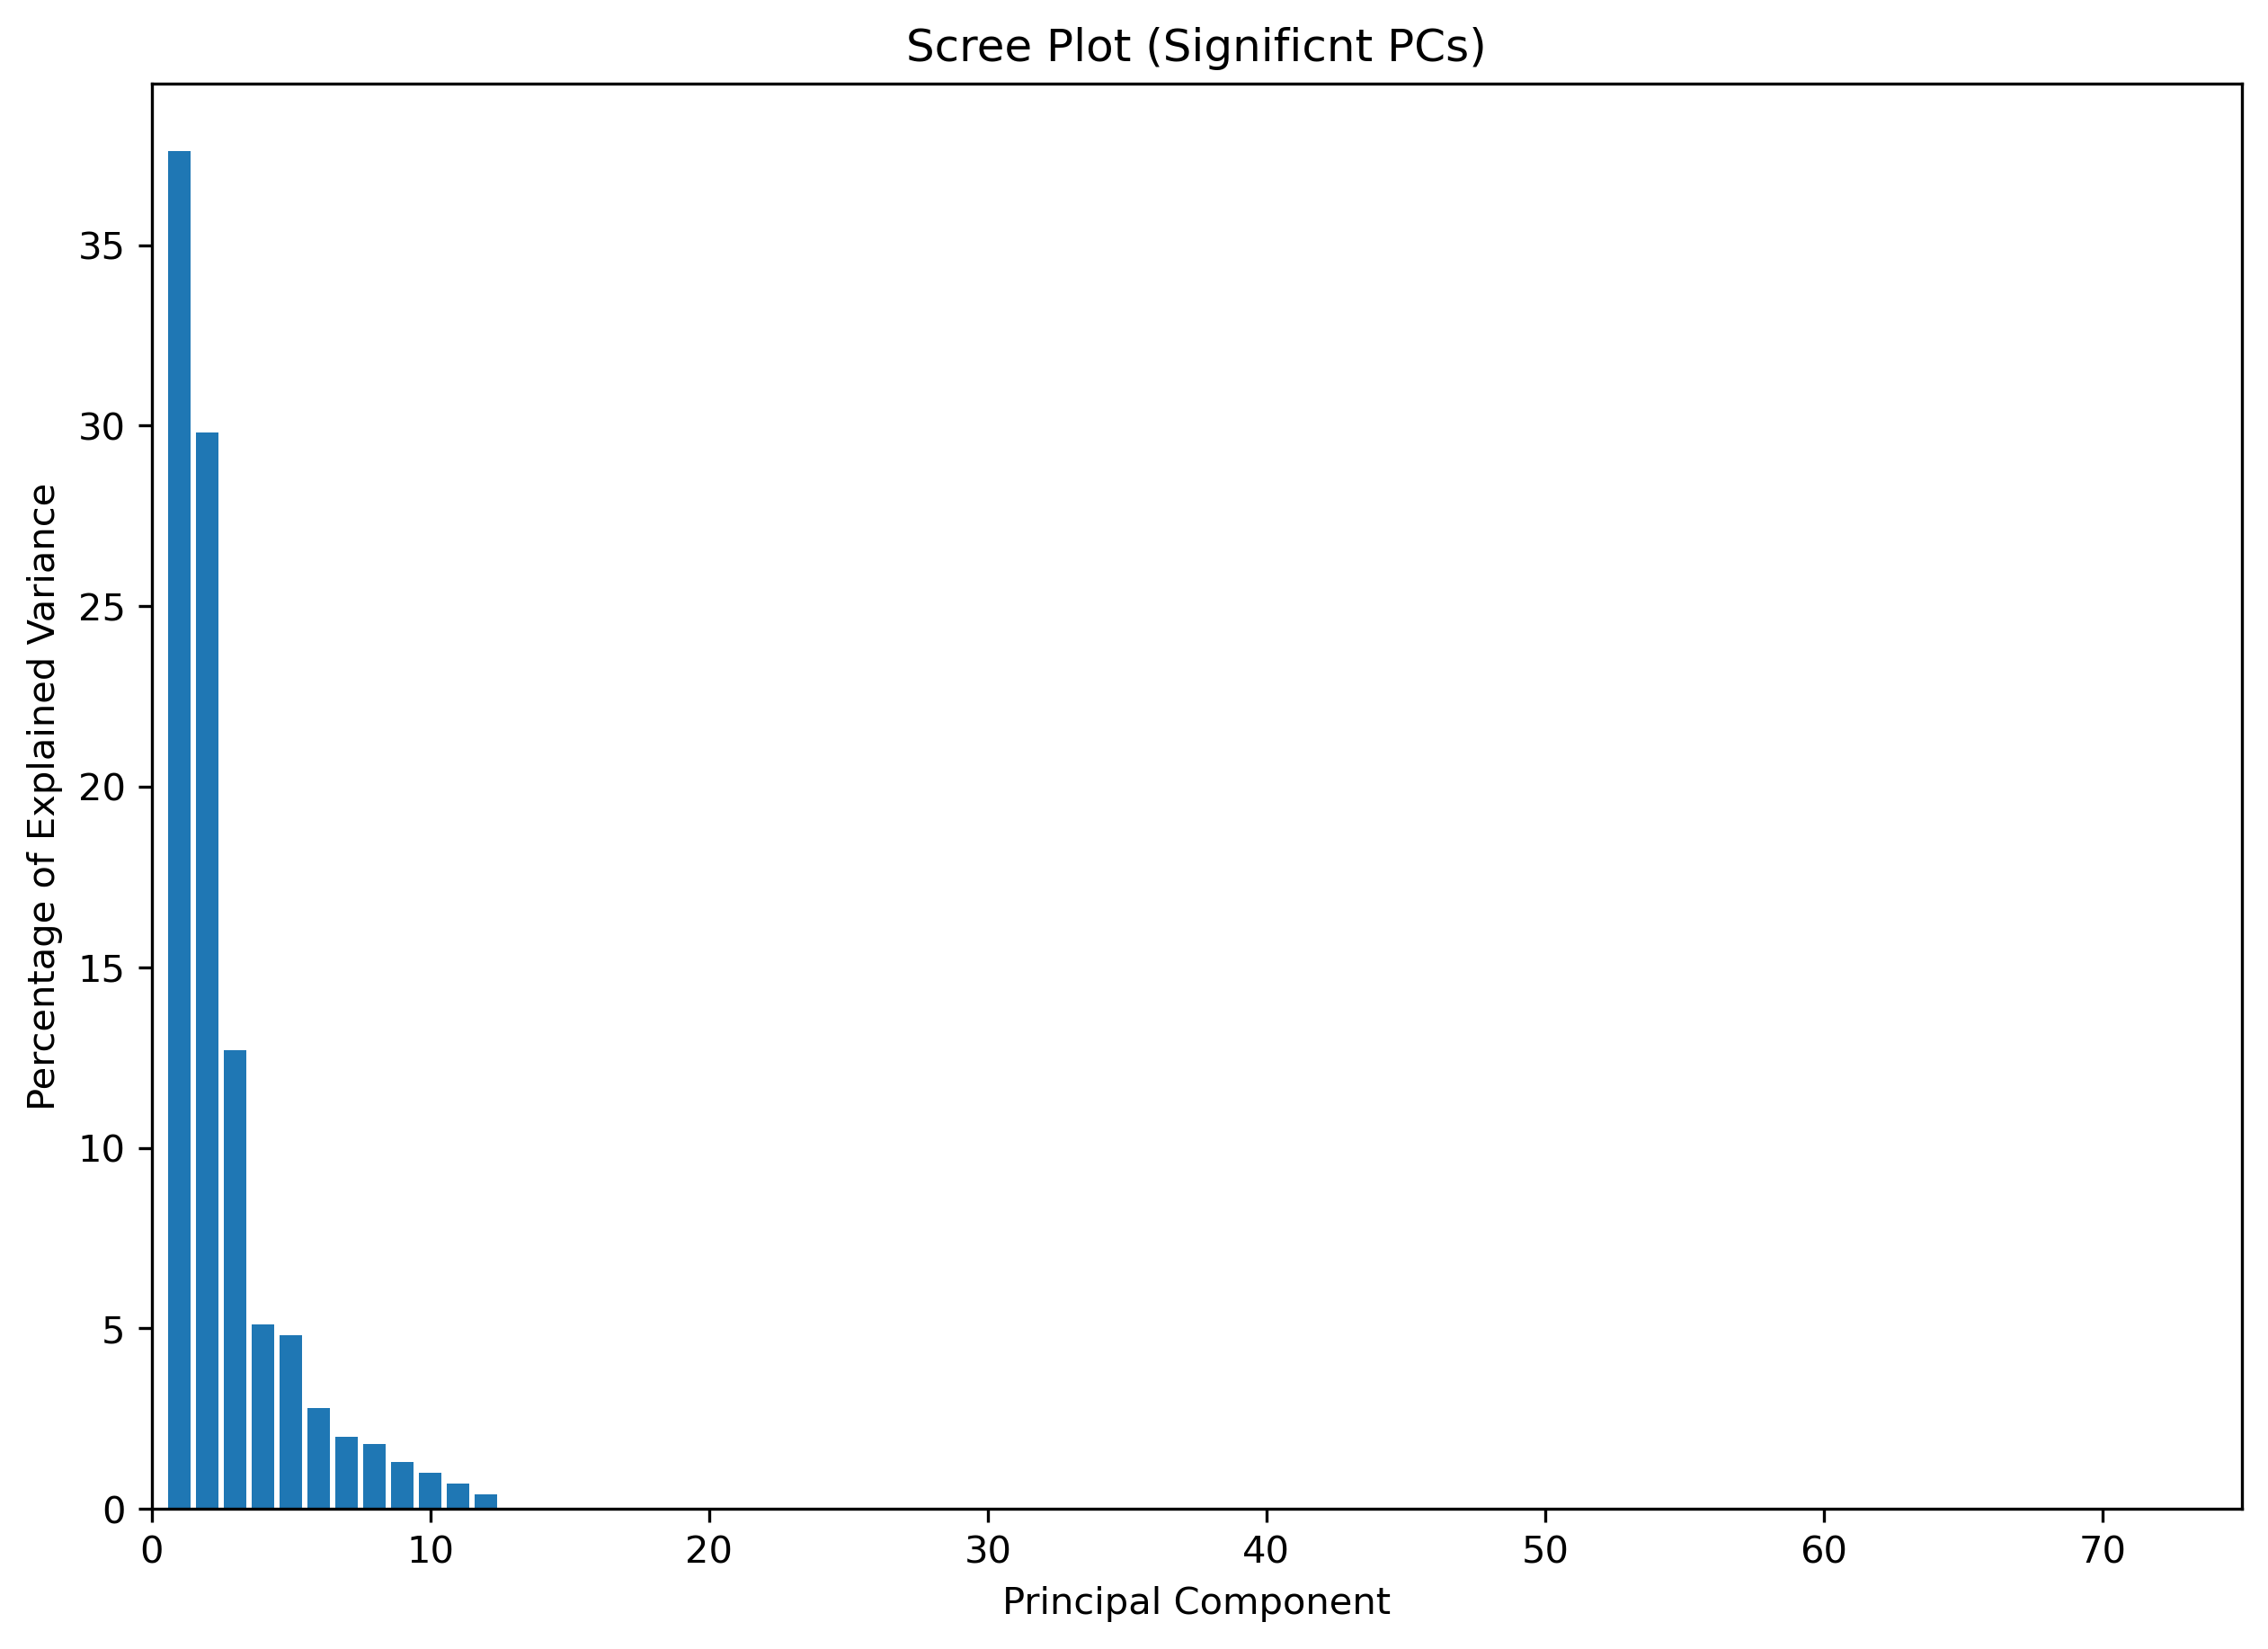

In [412]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [57]:
principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['K/P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Ni/P'] = X[:,9]
principalDf['Ni/Zn'] = X[:,10]
principalDf['Ni/Fe'] = X[:,11]
principalDf['Ni/K'] = X[:,12]
principalDf['Cu/K'] = X[:,13]

In [58]:
print(principalDf['area'].max())
print(principalDf['eccentricity'].max()) 
print(principalDf['equivalent_diameter'].max())
print(principalDf['major_axis_length'].max()) 
print(principalDf['minor_axis_length'].max()) 
print(principalDf['perimeter'].max()) 
print(principalDf['K'].max()) 
print(principalDf['K/P'].max()) 
print(principalDf['Ni'].max()) 
print(principalDf['Ni/P'].max())
print(principalDf['Ni/Zn'].max())
print(principalDf['Ni/Fe'].max())
print(principalDf['Ni/K'].max())
print(principalDf['Cu/K'].max()) 

4.125
0.9769395940802652
2.2917489221187703
4.373612352851659
2.4812696957111178
10.321067811865476
0.0008107276516966522
13.322492599487305
0.00012132191477576271
3.428638458251953
1.6828488111495972
2.031073808670044
4.388086795806885
146.30764770507812


In [60]:
print(principalDf['area'].median())
print(principalDf['eccentricity'].median()) 
print(principalDf['equivalent_diameter'].median())
print(principalDf['major_axis_length'].median()) 
print(principalDf['minor_axis_length'].median()) 
print(principalDf['perimeter'].median()) 
print(principalDf['K'].median()) 
print(principalDf['K/P'].median()) 
print(principalDf['Ni'].median()) 
print(principalDf['Ni/P'].median())
print(principalDf['Ni/Zn'].median())
print(principalDf['Ni/Fe'].median())
print(principalDf['Ni/K'].median())
print(principalDf['Cu/K'].median()) 

0.6875
0.7559289460184544
0.9356025796273888
1.1281521496355325
0.7371064447728443
2.414213562373095
4.2070010749739595e-05
1.1155935525894165
4.0804767195368186e-05
0.9645305275917053
0.04385962337255478
0.6382034420967102
0.9738719761371613
26.046876907348633


In [61]:
principalDf

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,K/P,Ni,Ni/P,Ni/K,Ni/Zn,Ni/Fe,Cu/K
0,-3.006349,0.319806,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.952824,0.000029,0.954267,1.001515,0.028558,0.405042,35.068970
1,-3.014873,-0.356706,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.971523,0.000043,1.457102,1.499813,0.056597,0.695318,26.500006
2,-2.975985,-0.126997,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.662167,0.000043,0.945927,1.428533,0.039203,0.452991,36.439644
3,2.411925,-2.077315,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.536909,0.000058,0.692463,1.289723,0.041986,0.974724,30.718239
4,1.141308,-1.356580,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,1.085488,0.000055,1.351316,1.244893,0.054387,0.732575,22.889378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,5.298707,2.273811,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,3.567846,0.000056,0.460403,0.129042,0.948419,0.594451,0.136061
550,15.431255,-1.858857,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,3.038787,0.000066,0.450156,0.148137,0.670883,0.528698,0.220808
551,1.054544,3.460564,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,4.389382,0.000034,0.335201,0.076366,0.536903,0.502415,0.142235
552,-1.476497,4.506086,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,3.086301,0.000029,0.286142,0.092714,0.938895,0.249982,0.098747


<AxesSubplot:>

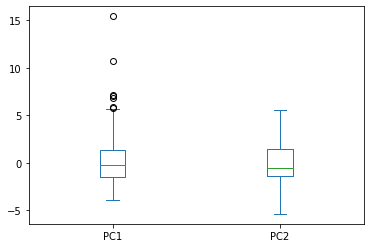

In [62]:
principalDf[['PC1','PC2']].plot.box()

<AxesSubplot:>

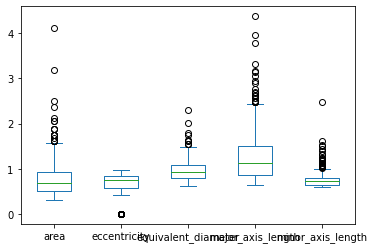

In [63]:
principalDf[['area','eccentricity', 'equivalent_diameter','major_axis_length','minor_axis_length']].plot.box()

<AxesSubplot:>

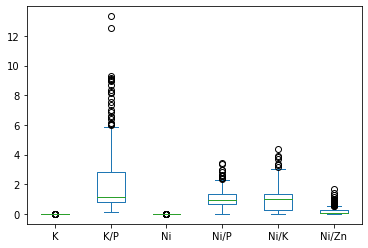

In [64]:
principalDf[['K','K/P', 'Ni','Ni/P','Ni/K','Ni/Zn']].plot.box()

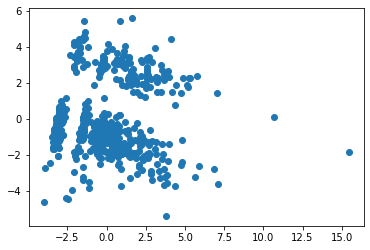

In [65]:
plt.scatter(principalDf['PC1'],principalDf['PC2'])

In [66]:
#Now assign labels based on group 1


In [414]:

# True_list = principalDf[principalDf['equivalent_diameter'] > 3.75].index.tolist()

# the length criterion

# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) 
#    ].index.tolist()

# the width criterion

# True_list = principalDf.loc[
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) 
#    ].index.tolist()

# the eccentricity criterion

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] >= 0.5) &
#     (principalDf['eccentricity'] <= 0.6) &
#     (principalDf['major_axis_length']<= 0.875)
#    ].index.tolist()

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] == 0)
#    ].index.tolist()



# Group 1
# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) 
    
#    ].index.tolist()

# Group 2 (live)
# K_threshold=4.2e-05 #default is median
# KbyP_threshold=1 #default is median
# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) &
#     (principalDf['K']>=K_threshold) &
#     (principalDf['K/P']>= KbyP_threshold)
#    ].index.tolist()

# Group 3 (Dead)
# Ni_threshold=2.04e-05 #default is half of median
# NibyP_threshold=0.48 #default is half of median

# NibyZn_threshold=0.021 #default is half of median
# NibyFe_threshold=0.32 #default is half of median
# NibyK_threshold=0.485 #default is half of median
# CubyK_threshold=13 #default is half of median

# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) &
#     (principalDf['Ni']>=Ni_threshold) &
#     (principalDf['Ni/P']>= NibyP_threshold) &
#     (principalDf['Ni/Zn']>= NibyZn_threshold) &
#     (principalDf['Ni/Fe']>= NibyFe_threshold) &
#     (principalDf['Ni/K']>= NibyK_threshold) &
#     (principalDf['Cu/K']>= CubyK_threshold)
#    ].index.tolist()


# Group 3' (Low Ni cells)
# Ni_threshold=2.04e-05 #default is half of median
# NibyP_threshold=0.48 #default is half of median

# NibyZn_threshold=0.021 #default is half of median
# NibyFe_threshold=0.32 #default is half of median
# NibyK_threshold=0.485 #default is half of median
# CubyK_threshold=13 #default is half of median

# True_list = principalDf.loc[
#     (principalDf['major_axis_length']>=1) & 
#     (principalDf['major_axis_length']<= 3) &
#     (principalDf['minor_axis_length']>=0.5) & 
#     (principalDf['minor_axis_length']<= 1.5) &
#     ((principalDf['Ni']<=Ni_threshold) |
#     (principalDf['Ni/P']<= NibyP_threshold) |
#     (principalDf['Ni/Zn']<= NibyZn_threshold) |
#     (principalDf['Ni/Fe']<= NibyFe_threshold) |
#     (principalDf['Ni/K']<= NibyK_threshold) |
#     (principalDf['Cu/K']<= CubyK_threshold))
#    ].index.tolist()

# Area criterion
True_list = principalDf.loc[
    (principalDf['area'] >= 2)
   ].index.tolist()



In [415]:
#create dataframe for group 1
DF_group1=principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) 
    
   ]

In [416]:
# True_list

In [417]:
len(True_list)

7

In [418]:
#view cells from the True_list

def viewer(idx):

    plt.imshow(X_bin[True_list[idx]]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(True_list)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=3, description='idx', max=6), Output()), _dom_classes=('widget-interact'…

In [419]:
labels=np.zeros(X.shape[0])
labels.shape
for idx in True_list:
    labels[idx]=1
principalDf['labels'] = labels.astype('bool')

In [420]:
# principalDf

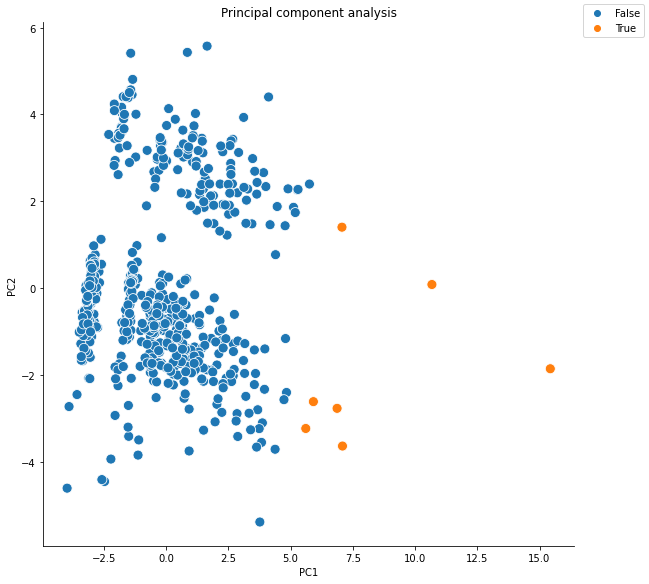

In [421]:
#with histogram

# pp = sns.pairplot(principalDf[['PC1','PC2', 'labels']], kind = 'scatter', 
#                  diag_kind='hist', corner = 'True', hue = 'labels', height=4)

# pp = sns.pairplot(data=principalDf,
#                   y_vars=['PC2'],
#                   x_vars=['PC1'],
#                   kind = 'scatter', 
#                  diag_kind='hist', corner = 'True', hue='labels', height=8
#                  )

pp = sns.pairplot(data=principalDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [306]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]


# the artifact criterion Group 0

True_list = principalDf.loc[
    (principalDf['eccentricity'] == 0)
    
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 0: Artifact, e = 0'

# Group 1
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) 
    
   ].index.tolist()
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 1: Only Shape'
    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=K_threshold) &
    (principalDf['K/P']>= KbyP_threshold)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 2: Shape + Live'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=Ni_threshold) &
    (principalDf['Ni/P']>= NibyP_threshold) &
    (principalDf['Ni/Zn']>= NibyZn_threshold) &
    (principalDf['Ni/Fe']>= NibyFe_threshold) &
    (principalDf['Ni/K']>= NibyK_threshold) &
    (principalDf['Cu/K']>= CubyK_threshold)
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 3: Shape + Dead' 
    

# Shape plus either live and dead criterion
True_list = principalDf.loc[    
(principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=K_threshold) &
    (principalDf['K/P']>= KbyP_threshold) &
    (principalDf['Ni']>=Ni_threshold) &
    (principalDf['Ni/P']>= NibyP_threshold) &
    (principalDf['Ni/Zn']>= NibyZn_threshold) &
    (principalDf['Ni/Fe']>= NibyFe_threshold) &
    (principalDf['Ni/K']>= NibyK_threshold) &
    (principalDf['Cu/K']>= CubyK_threshold)
    ].index.tolist()
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 4: Shape + Live+ Dead'
    


    
    
# the eccentricity criterion

True_list = principalDf.loc[
    (principalDf['eccentricity'] >= 0.5) &
    (principalDf['eccentricity'] <= 0.6) &
    (principalDf['major_axis_length']<= 0.875)
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 5: 0.5 <= e <=0.6, l<=0.975'
    

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'Group 6: outlier/undetermined'
    
principalDf['text_labels'] = labels


132
337
147
220
47
76


In [307]:
labels

['Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 4: Shape + Live+ Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 5: 0.5 <= e <=0.6, l<=0.975',
 'Group 1: Only Shape',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 1: Only Shape',
 'Group 4: Shape + Live+ Dead',
 'Group 6: outlier/undetermined',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 3: Shape + Dead',
 'Group 4: Shape + Live+ Dead',
 'Group 3: Shape + Dead',
 'Group 3: Shape + Dead',
 'Group 4: Shape + Live+ Dead',
 'Group 5: 0.5 <= e <=0.6, l<=0.975',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Group 4: Shape + Live+ Dead',
 'Group 4: Shape + Live+ Dead',
 'Group 3: Shape + Dead',
 'Group 4: Shape + Live+ Dead',
 'Group 0: Artifact, e = 0',
 'Group 0: Artifact, e = 0',
 'Group 5: 0.5 <= e <=0.6, l<=0.975',
 'Group 3: Shape + Dead',
 'Group 0: Artifact, e = 0',
 'Gr

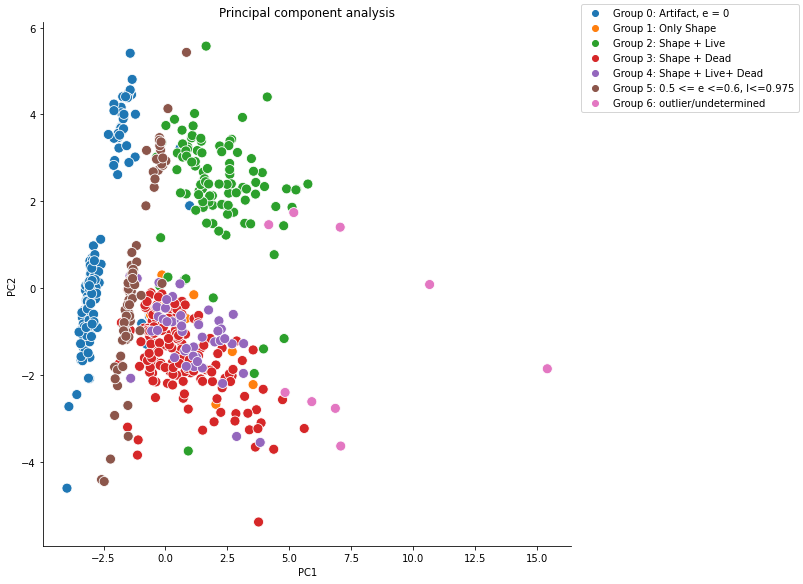

In [338]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



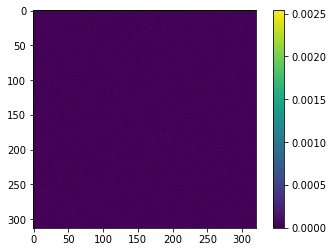

In [303]:
plt.imshow(x.d_Cu)
plt.colorbar()

In [52]:
for idx in range(len(x.Patches_Cu)):
    print(np.amax(x.Patches_Cu[idx]))

0.0010020182
0.000767755
0.0010927443
0.0013706799
0.001019034
0.0008177221
0.0015646245
0.0011703358
0.0016137457
0.0013349594
0.001045111
0.0013690343
0.0011015538
0.0014515882
0.0012581204
0.0011038417
0.0006895297
0.0010298706
0.0014050383
0.001460574
0.0010544123
0.0013210574
0.0013908886
0.00095728494
0.0009294593
0.0015431119
0.0010829159
0.0013796131
0.0014960736
0.0012486307
0.00090363587
0.0010495367
0.0010795397
0.0009570743
0.0007729839
0.0011936862
0.0015644433
0.0013062195
0.0012967071
0.0011105876
0.0011030621
0.0012521291
0.0012495827
0.0008774807
0.0015677342
0.0023290406
0.0017216912
0.001303432
0.0011680744
0.0014408727
0.0016483053
0.0010946537
0.0010047435
0.001462597
0.0012128466
0.0011713408
0.0011054556
0.0014861012
0.0012426138
0.0012309963
0.001431109
0.0018929685
0.0011026202
0.0011707048
0.00096260756
0.0017051183
0.0011334708
0.0010576684
0.000916605
0.0012256845
0.0010326623
0.0012785621
0.0012440927
0.0012101486
0.0010030156
0.0016182541
0.0016177065
0.00

In [55]:
def viewer(idx):
#     plt.imshow(Patches_Cu[idx]);
    plt.imshow(x.binary_img[idx]);
#     plt.imshow(region_vals[idx]);
    
    plt.title('Current channel')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
    plt.grid(True)
    plt.show()
    
    n, bins, boxes = plt.hist(x.region_vals[idx].astype(int), 10, density=True)
    plt.title('histogram of binary image')

interactive_plot = interactive(viewer, idx=(0, len(x.Patches_Cu)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=54, description='idx', max=109), Output()), _dom_classes=('widget-intera…

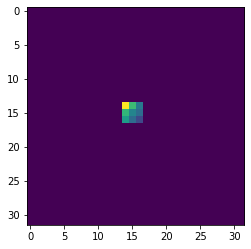

In [10]:
plt.imshow(Patches_Cu[0])

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1

label_img = label(image)
regions = regionprops(label_img)

99.82399501007846

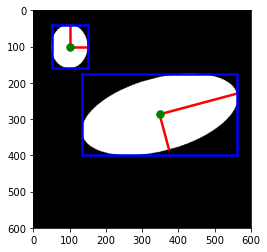

In [7]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()


In [ ]:
#end